In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
import requests


[[ 1.76607776e+03]
 [-1.76019485e+03]
 [-2.45376994e+01]
 ...
 [-1.83431965e+03]
 [-2.22578294e+04]
 [-4.01248949e+04]]


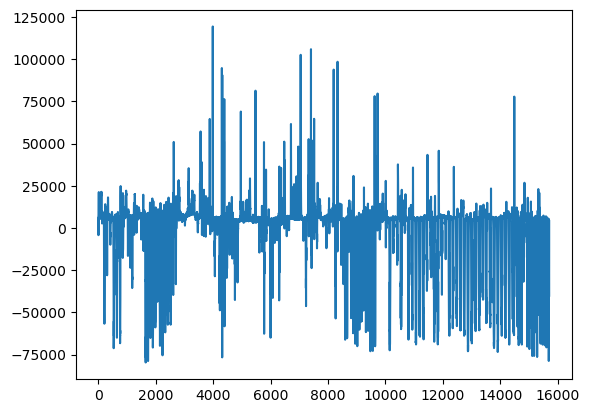

In [81]:
training_set_df = pd.read_csv("power_usage.csv")

training_set = training_set_df.iloc[:, 2:3].values
print(training_set)
training_set = [i for i in training_set if float(i) > -100000]
plt.plot(training_set)
plt.show()

In [82]:
# How many hours? 6? So 6 hours is 36
seq_length = 36

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [83]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length=5):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out


In [84]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [85]:
criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
early_stop = 50
least_loss = np.inf
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    if least_loss > loss.item():
       least_loss = loss.item()
       early_stop = 50
    else:
       early_stop -= 1
    
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
    if early_stop <= 0:
      print("Epoch: %d, loss: %1.5f, best_loss: %1.5f" % (epoch, loss.item(), least_loss))


Epoch: 0, loss: 0.23006
Epoch: 100, loss: 0.00653
Epoch: 200, loss: 0.00497
Epoch: 300, loss: 0.00194
Epoch: 400, loss: 0.00120
Epoch: 500, loss: 0.00091
Epoch: 600, loss: 0.00075
Epoch: 700, loss: 0.00066
Epoch: 800, loss: 0.00060
Epoch: 900, loss: 0.00057
Epoch: 1000, loss: 0.00056
Epoch: 1100, loss: 0.00055
Epoch: 1200, loss: 0.00055
Epoch: 1300, loss: 0.00055
Epoch: 1400, loss: 0.00055
Epoch: 1500, loss: 0.00055
Epoch: 1600, loss: 0.00054
Epoch: 1700, loss: 0.00054
Epoch: 1800, loss: 0.00054
Epoch: 1900, loss: 0.00054


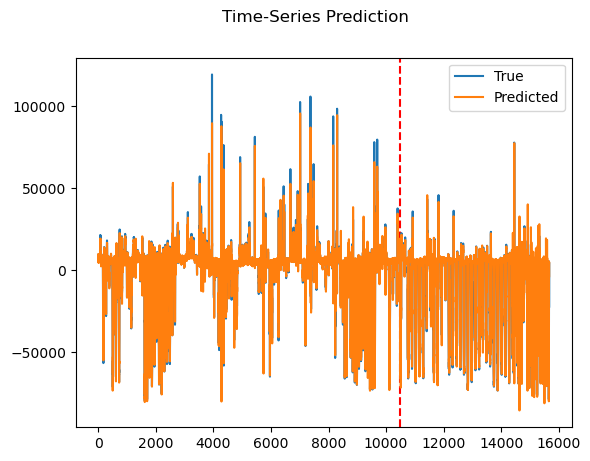

In [86]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#Plot the Predictions
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label="True")
plt.plot(data_predict, label="Predicted")
plt.legend()
plt.suptitle('Time-Series Prediction')
plt.show()

In [104]:
'''
Implement MSE calculation for the test data
'''
lstm.eval()
test_predictions = lstm(testX)
test_loss = criterion(test_predictions, testY)


print(f"Test Loss for model trained 2000 epochs: {test_loss.item()}")


Test Loss for model trained 2000 epochs: 0.0011644181795418262


In [88]:
# Get the last 37 points of 10 minute chunks (so if every 5 seconds, that is 4320) and predict what the prices will be
response = requests.get(f"http://144.39.204.242:11236/evr/leviton/evr?limit=4320")
usage = response.json()
ten_minute_averages = {"timestamp": [], "power": []}

for i in range(0, len(usage['data']), 85):
    values = usage['data'][i:i+120]
    power = [value['power'] for value in values]
    ten_minute_averages["timestamp"].append(values[0]['timestamp'])
    ten_minute_averages["power"].append(np.average(power) * 1000)

power = ten_minute_averages["power"]
power = [[i] for i in power]
power = np.array(power)

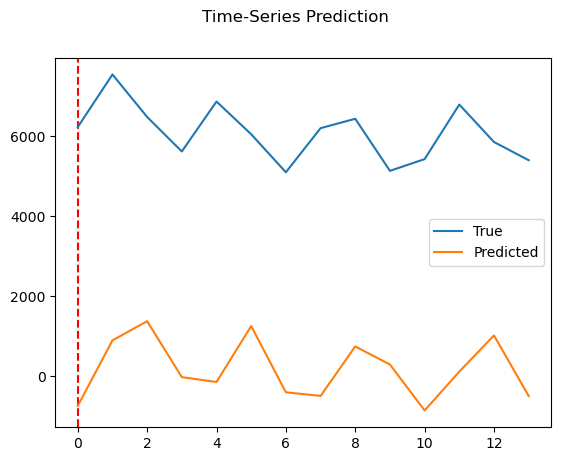

In [90]:
power = sc.fit_transform(power)
testNewX, testNewY = sliding_windows(power, seq_length)
testDataX = Variable(torch.Tensor(np.array(testNewX[0:len(testNewX)])))
testDataY = Variable(torch.Tensor(np.array(testNewY[0:len(testNewY)])))

lstm.eval()
test_predict = lstm(testDataX)

data_predict = test_predict.data.numpy()
dataY_test_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(testDataY)

#Plot the Predictions
plt.axvline(x=0, c='r', linestyle='--')

plt.plot(dataY_plot, label="True")
plt.plot(data_predict, label="Predicted")
plt.legend()
plt.suptitle('Time-Series Prediction')
plt.show()

In [119]:
# How many hours? 6? So 6 hours is 36
seq_length = 36

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [120]:
num_epochs = 5000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1

lstm_5000 = LSTM(num_classes, input_size, hidden_size, num_layers)

In [121]:
criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(lstm_5000.parameters(), lr=learning_rate)
early_stop = 50
least_loss = np.inf
# Train the model
for epoch in range(num_epochs):
    outputs = lstm_5000(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    if least_loss > round(loss.item(), 7):
      #  print("Better!")
      #  print(loss.item())
      #  print(least_loss)
       least_loss = round(loss.item(), 7)
       early_stop = 50
    else:
       early_stop -= 1
    
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f, early stop: %d" % (epoch, loss.item(), early_stop))
    
    if early_stop <= 0:
      print("Epoch: %d, loss: %1.5f, best_loss: %1.5f" % (epoch, loss.item(), least_loss))
      break


Epoch: 0, loss: 0.01545, early stop: 50
Epoch: 100, loss: 0.00205, early stop: 50
Epoch: 200, loss: 0.00096, early stop: 50
Epoch: 300, loss: 0.00076, early stop: 50
Epoch: 400, loss: 0.00066, early stop: 50
Epoch: 500, loss: 0.00058, early stop: 50
Epoch: 600, loss: 0.00054, early stop: 50
Epoch: 700, loss: 0.00053, early stop: 46
Epoch: 800, loss: 0.00053, early stop: 19
Epoch: 900, loss: 0.00053, early stop: 32
Epoch: 1000, loss: 0.00053, early stop: 20
Epoch: 1100, loss: 0.00053, early stop: 9
Epoch: 1200, loss: 0.00053, early stop: 39
Epoch: 1300, loss: 0.00053, early stop: 22
Epoch: 1400, loss: 0.00053, early stop: 41
Epoch: 1500, loss: 0.00053, early stop: 17
Epoch: 1600, loss: 0.00053, early stop: 25
Epoch: 1700, loss: 0.00053, early stop: 26
Epoch: 1800, loss: 0.00053, early stop: 21
Epoch: 1900, loss: 0.00053, early stop: 40
Epoch: 2000, loss: 0.00053, early stop: 50
Epoch: 2100, loss: 0.00053, early stop: 31
Epoch: 2200, loss: 0.00053, early stop: 46
Epoch: 2300, loss: 0.000

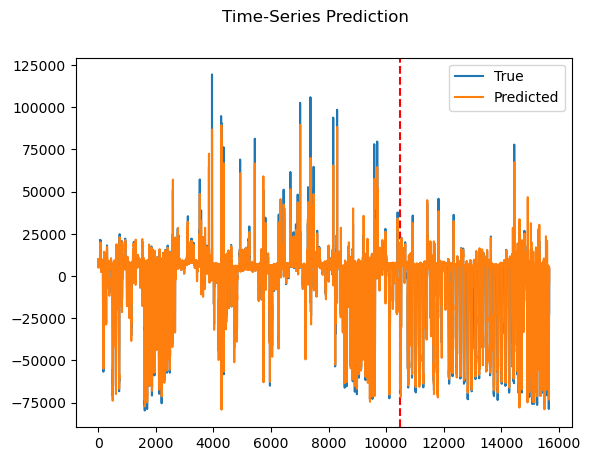

In [122]:
lstm_5000.eval()
train_predict = lstm_5000(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#Plot the Predictions
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label="True")
plt.plot(data_predict, label="Predicted")
plt.legend()
plt.suptitle('Time-Series Prediction')
plt.show()

In [123]:
'''
Implement MSE calculation for the test data
'''
lstm_5000.eval()
test_predictions = lstm_5000(testX)
test_loss = criterion(test_predictions, testY)


print(f"Test Loss for model trained 2000 epochs: {test_loss.item()}")

Test Loss for model trained 2000 epochs: 0.0011235160054638982


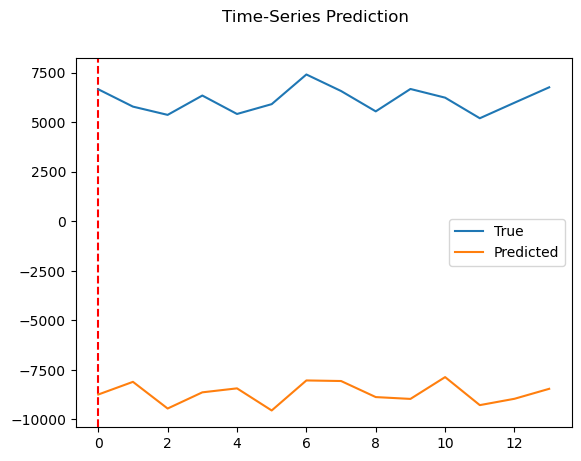

In [124]:
# Get the last 37 points of 10 minute chunks (so if every 5 seconds, that is 4320) and predict what the prices will be
response = requests.get(f"http://144.39.204.242:11236/evr/leviton/evr?limit=4320")
usage = response.json()
ten_minute_averages = {"timestamp": [], "power": []}

for i in range(0, len(usage['data']), 85):
    values = usage['data'][i:i+120]
    power = [value['power'] for value in values]
    ten_minute_averages["timestamp"].append(values[0]['timestamp'])
    ten_minute_averages["power"].append(np.average(power) * 1000)

power = ten_minute_averages["power"]
power = [[i] for i in power]
power = np.array(power)

power = sc.fit_transform(power)
testNewX, testNewY = sliding_windows(power, seq_length)
testDataX = Variable(torch.Tensor(np.array(testNewX[0:len(testNewX)])))
testDataY = Variable(torch.Tensor(np.array(testNewY[0:len(testNewY)])))

lstm_5000.eval()
test_predict = lstm_5000(testDataX)

data_predict = test_predict.data.numpy()
dataY_test_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(testDataY)

#Plot the Predictions
plt.axvline(x=0, c='r', linestyle='--')

plt.plot(dataY_plot, label="True")
plt.plot(data_predict, label="Predicted")
plt.legend()
plt.suptitle('Time-Series Prediction')
plt.show()

Epoch: 0, loss: 0.02495
Epoch: 100, loss: 0.00407
Epoch: 200, loss: 0.00234
Epoch: 300, loss: 0.00143
Epoch: 400, loss: 0.00120
Epoch: 500, loss: 0.00105
Epoch: 600, loss: 0.00095
Epoch: 700, loss: 0.00087
Epoch: 800, loss: 0.00081
Epoch: 900, loss: 0.00076
Epoch: 1000, loss: 0.00072
Epoch: 1100, loss: 0.00068
Epoch: 1200, loss: 0.00066
Epoch: 1300, loss: 0.00063
Epoch: 1400, loss: 0.00062
Epoch: 1500, loss: 0.00060
Epoch: 1600, loss: 0.00059
Epoch: 1700, loss: 0.00058
Epoch: 1800, loss: 0.00058
Epoch: 1900, loss: 0.00057
Epoch: 0, loss: 0.44366
Epoch: 100, loss: 0.00586
Epoch: 200, loss: 0.00533
Epoch: 300, loss: 0.00460
Epoch: 400, loss: 0.00369
Epoch: 500, loss: 0.00265
Epoch: 600, loss: 0.00173
Epoch: 700, loss: 0.00127
Epoch: 800, loss: 0.00114
Epoch: 900, loss: 0.00107
Epoch: 1000, loss: 0.00102
Epoch: 1100, loss: 0.00097
Epoch: 1200, loss: 0.00094
Epoch: 1300, loss: 0.00090
Epoch: 1400, loss: 0.00087
Epoch: 1500, loss: 0.00084
Epoch: 1600, loss: 0.00082
Epoch: 1700, loss: 0.0008

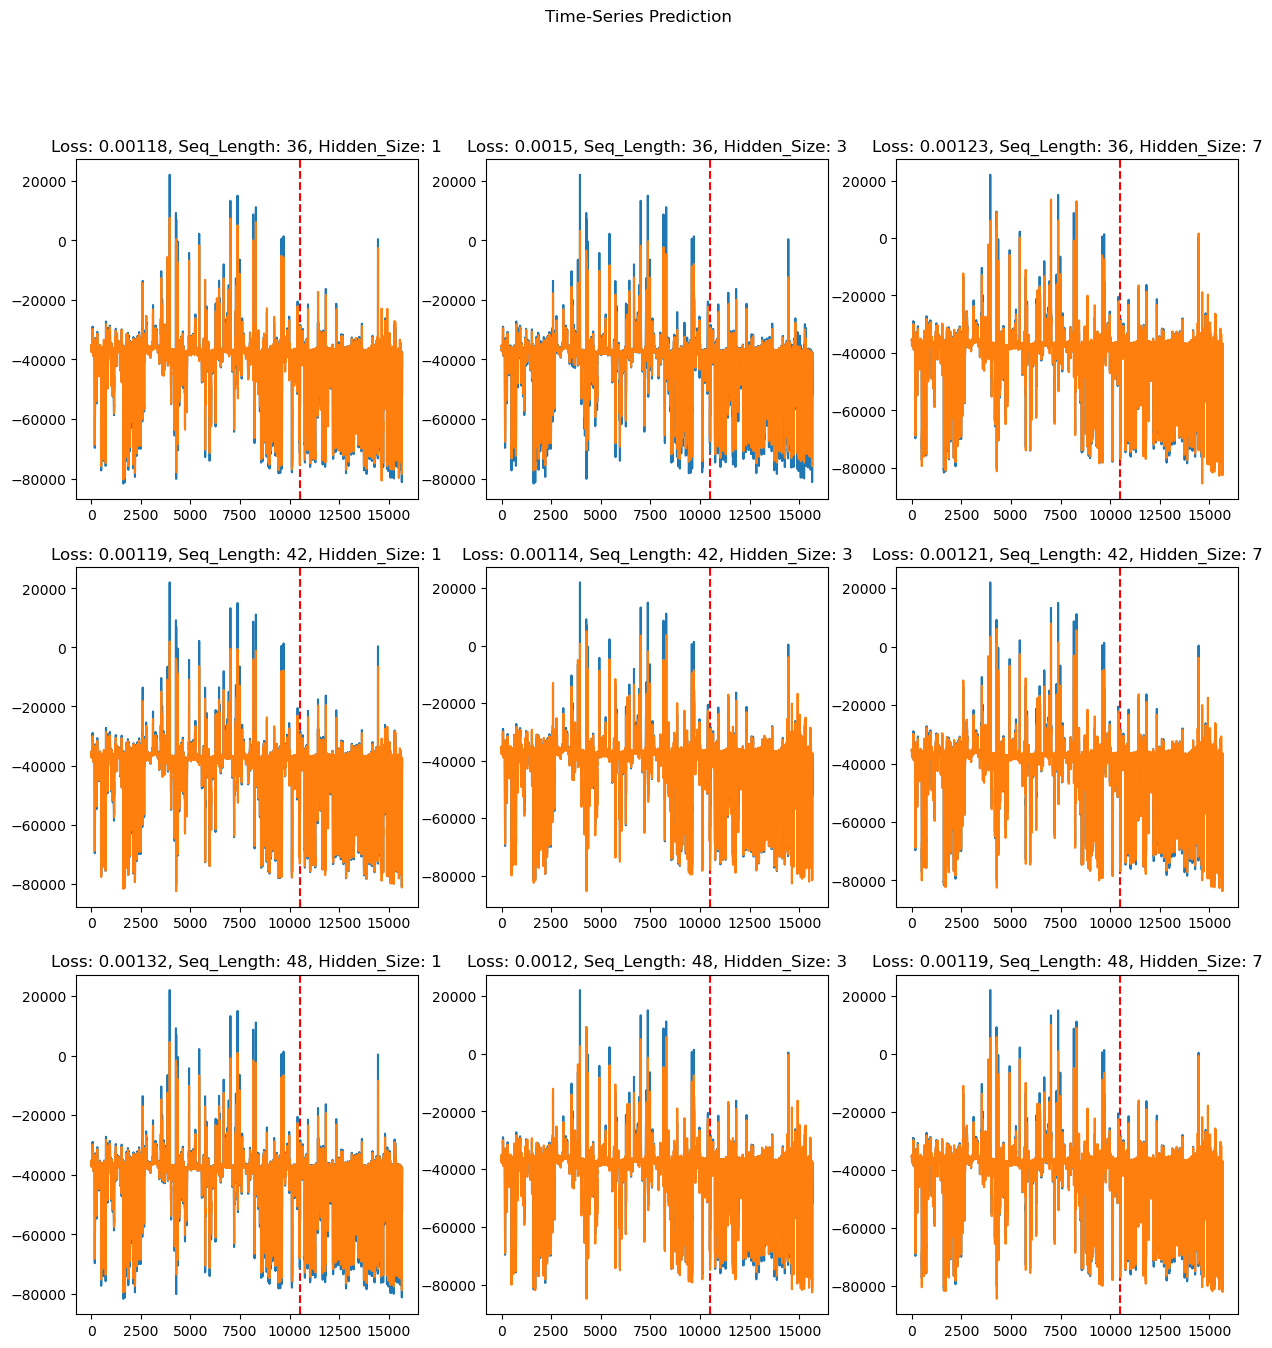

In [125]:
seq_lengths = [36, 42, 48] # We did 5 previously
hidden_sizes = [1, 3, 7] # We did 2 previously
num_epochs = 2000
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, seq_length in enumerate(seq_lengths):
    for j, hidden_size in enumerate(hidden_sizes):
        lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)
        early_stop = 50
        least_loss = np.inf
        criterion = torch.nn.MSELoss()    
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

        # Train the model
        for epoch in range(num_epochs):
            outputs = lstm(trainX)
            optimizer.zero_grad()
            
            # obtain the loss function
            loss = criterion(outputs, trainY)
            loss.backward()
            optimizer.step()
            
            if least_loss > loss.item():
                least_loss = loss.item()
                early_stop = 50
            else:
                early_stop -= 1

            if epoch % 100 == 0:
                print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
            
            if early_stop <= 0:
                print("Epoch: %d, loss: %1.5f, best_loss: %1.5f" % (epoch, loss.item(), least_loss))
                break

        lstm.eval()
        train_predict = lstm(dataX)

        data_predict = train_predict.data.numpy()
        dataY_plot = dataY.data.numpy()

        data_predict = sc.inverse_transform(data_predict)
        dataY_plot = sc.inverse_transform(dataY_plot)

        lstm.eval()
        test_predictions = lstm(testX)
        test_loss = criterion(test_predictions, testY)
        #Plot the Predictions
        ax[i][j].axvline(x=train_size, c='r', linestyle='--')
        ax[i][j].set_title(f"Loss: {round(test_loss.item(), 5)}, Seq_Length: {seq_length}, Hidden_Size: {hidden_size}")

        ax[i][j].plot(dataY_plot)
        ax[i][j].plot(data_predict)


plt.suptitle('Time-Series Prediction')
plt.show()

In [127]:
# How many hours? 6? So 6 hours is 36
seq_length = 42

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))

num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 3
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [128]:
criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
early_stop = 50
least_loss = np.inf
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    if least_loss > loss.item():
       least_loss = loss.item()
       early_stop = 50
    else:
       early_stop -= 1
    
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
    if early_stop <= 0:
      print("Epoch: %d, loss: %1.5f, best_loss: %1.5f" % (epoch, loss.item(), least_loss))


Epoch: 0, loss: 0.08039
Epoch: 100, loss: 0.00429
Epoch: 200, loss: 0.00131
Epoch: 300, loss: 0.00108
Epoch: 400, loss: 0.00095
Epoch: 500, loss: 0.00085
Epoch: 600, loss: 0.00077
Epoch: 700, loss: 0.00071
Epoch: 800, loss: 0.00065
Epoch: 900, loss: 0.00061
Epoch: 1000, loss: 0.00058
Epoch: 1100, loss: 0.00056
Epoch: 1200, loss: 0.00056
Epoch: 1300, loss: 0.00055
Epoch: 1400, loss: 0.00055
Epoch: 1500, loss: 0.00055
Epoch: 1600, loss: 0.00055
Epoch: 1700, loss: 0.00055
Epoch: 1800, loss: 0.00055
Epoch: 1900, loss: 0.00054


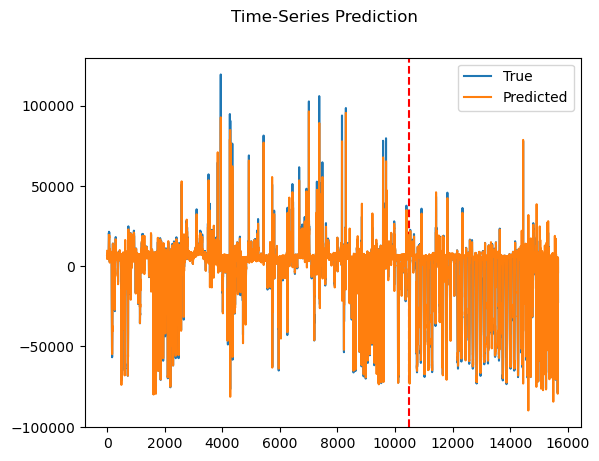

In [129]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#Plot the Predictions
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label="True")
plt.plot(data_predict, label="Predicted")
plt.legend()
plt.suptitle('Time-Series Prediction')
plt.show()

In [130]:
'''
Implement MSE calculation for the test data
'''
lstm.eval()
test_predictions = lstm(testX)
test_loss = criterion(test_predictions, testY)


print(f"Test Loss for model trained 2000 epochs: {test_loss.item()}")

c:\Users\sonor\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([5171, 1])) that is different to the input size (torch.Size([5169, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (5169) must match the size of tensor b (5171) at non-singleton dimension 0

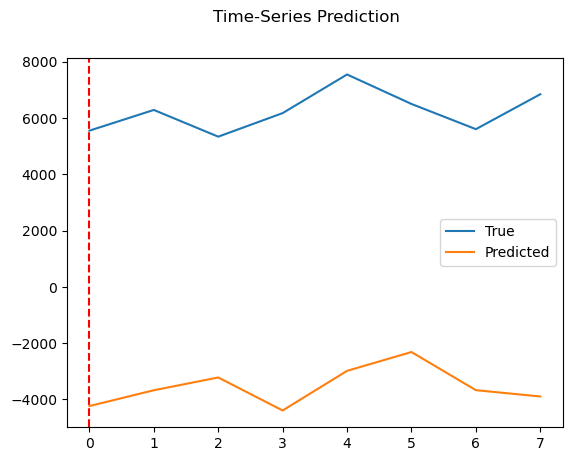

In [131]:
# Get the last 37 points of 10 minute chunks (so if every 5 seconds, that is 4320) and predict what the prices will be
response = requests.get(f"http://144.39.204.242:11236/evr/leviton/evr?limit=4320")
usage = response.json()
ten_minute_averages = {"timestamp": [], "power": []}

for i in range(0, len(usage['data']), 85):
    values = usage['data'][i:i+120]
    power = [value['power'] for value in values]
    ten_minute_averages["timestamp"].append(values[0]['timestamp'])
    ten_minute_averages["power"].append(np.average(power) * 1000)

power = ten_minute_averages["power"]
power = [[i] for i in power]
power = np.array(power)

power = sc.fit_transform(power)
testNewX, testNewY = sliding_windows(power, seq_length)
testDataX = Variable(torch.Tensor(np.array(testNewX[0:len(testNewX)])))
testDataY = Variable(torch.Tensor(np.array(testNewY[0:len(testNewY)])))

lstm.eval()
test_predict = lstm(testDataX)

data_predict = test_predict.data.numpy()
dataY_test_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(testDataY)

#Plot the Predictions
plt.axvline(x=0, c='r', linestyle='--')

plt.plot(dataY_plot, label="True")
plt.plot(data_predict, label="Predicted")
plt.legend()
plt.suptitle('Time-Series Prediction')
plt.show()